In [1]:
# IMPORTS
import mne
from os.path import join
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# PREPROCESSING FUNCTIONS
def preprocess_sensor_space_data(subject, date, raw_path,
                                 h_freq=40,
                                 tmin=-0.200, tmax=1.000, baseline=(None, 0),
                                 reject=None, decim=4, reject_criterion=None):
    recording_names = ['001.self_block1',  '002.other_block1',
                       '003.self_block2',  '004.other_block2',
                       '005.self_block3',  '006.other_block3']
    epochs_list = list()
    for recording_index, recording_name in enumerate(recording_names):
        fif_fname = recording_name[4:]
        full_path = join(raw_path, subject, date, 'MEG', recording_name,
                         'files', fif_fname + '.fif')
        print(full_path)
        raw = mne.io.read_raw(full_path, preload=True)
        
        raw.filter(l_freq=None, h_freq=h_freq, n_jobs=3)
        
        events = mne.find_events(raw, min_duration=0.002)
        if 'self' in recording_name:
            event_id = dict(self_positive=11, self_negative=12,
                            button_press=23)
        elif 'other' in recording_name: 
            event_id = dict(other_positive=21, other_negative=22,
                            button_press=23)
        else:
            raise NameError('Event codes are not coded for file')
        
        # added a epoching function which includes a reject criterion that was not present in OG script
        epochs = mne.Epochs(raw, events, event_id, tmin=tmin, tmax=tmax,
                    baseline=(None, 0), reject=reject_criterion, preload=True,
                    proj=False)
        
        epochs_list.append(epochs)
        
        if recording_index == 0:
            X = epochs.get_data()
            y = epochs.events[:, 2]
        else:
            X = np.concatenate((X, epochs.get_data()), axis=0)
            y = np.concatenate((y, epochs.events[:, 2]))
    
    return epochs_list


def preprocess_source_space_data(subject, date, raw_path, subjects_dir,
                                 epochs_list,
                              method='MNE', lambda2=1, pick_ori='normal',
                              label=None):
    if epochs_list is None:
        epochs_list = preprocess_sensor_space_data(subject, date, raw_path,
                                                   return_epochs=True)
    y = np.zeros(0)
    for epochs in epochs_list: # get y
        y = np.concatenate((y, epochs.events[:, 2]))
    
    if label is not None:
        label_path = join(subjects_dir, subject, 'label', label)
        label = mne.read_label(label_path)
        
    recording_names = ['001.self_block1',  '002.other_block1',
                       '003.self_block2',  '004.other_block2',
                       '005.self_block3',  '006.other_block3']
    for epochs_index, epochs in enumerate(epochs_list): ## get X
        
        fwd_fname = recording_names[epochs_index][4:] + '-oct-6-src-' + \
                    '5120-fwd.fif'
        fwd = mne.read_forward_solution(join(subjects_dir,
                                             subject, 'bem', fwd_fname))
        noise_cov = mne.compute_covariance(epochs, tmax=0.000)
        inv = mne.minimum_norm.make_inverse_operator(epochs.info,
                                                     fwd, noise_cov)
  
        stcs = mne.minimum_norm.apply_inverse_epochs(epochs, inv, lambda2,
                                                     method, label,
                                                     pick_ori=pick_ori)
        for stc_index, stc in enumerate(stcs):
            this_data = stc.data
            if epochs_index == 0 and stc_index == 0:
                n_trials = len(stcs)
                n_vertices, n_samples = this_data.shape
                this_X = np.zeros(shape=(n_trials, n_vertices, n_samples))
            this_X[stc_index, :, :] = this_data
            
        if epochs_index == 0:
            X = this_X
        else:
            X = np.concatenate((X, this_X))
    return X, y

def get_X_and_y(epochs_list):
    for recording_index in range(len(epochs_list)):
        these_epochs = epochs_list[recording_index]
        if recording_index == 0:
            X = these_epochs.get_data()
            y = these_epochs.events[:, 2]
        else:
            X = np.concatenate((X, these_epochs.get_data()), axis=0)
            y = np.concatenate((y, these_epochs.events[:, 2]))
            
    return X, y

In [ ]:
# DEFINE PATHS
import pathlib
path = pathlib.Path.cwd()

raw_path = path.parents[2] / "834761"
subjects_dir = path.parents[2] / "835482" 

In [ ]:
# RUNNING FUNCTIONS
epochs_list = preprocess_sensor_space_data('0114', '20230927_000000',
        raw_path=raw_path,
        decim=10) ##CHANGE TO YOUR PATHS # don't go above decim=10

times = epochs_list[0].times # get time points for later

X_sensor, y = get_X_and_y(epochs_list)

X_source, y = preprocess_source_space_data('0114', '20230927_000000',
        raw_path=raw_path,
        subjects_dir=subjects_dir,
        epochs_list=epochs_list) ##CHANGE TO YOUR PATHS

X_lh_BA44, y = preprocess_source_space_data('0114', '20230927_000000',
        raw_path=raw_path,
        subjects_dir=subjects_dir,
        label='lh.BA44_exvivo.label', epochs_list=epochs_list)
        ##CHANGE TO YOUR PATHS
        
X_lh_V1, y = preprocess_source_space_data('0114', '20230927_000000',
        raw_path=raw_path,
        subjects_dir=subjects_dir,
        label='lh.V1_exvivo.label', epochs_list=epochs_list)
        ##CHANGE TO YOUR PATHS

In [6]:
# SIMPLE CLASSIFICATION
def get_indices(y, triggers):
    indices = list()
    for trigger_index, trigger in enumerate(y):
        if trigger in triggers:
            indices.append(trigger_index)
            
    return indices

def equalize_number_of_indices(): # write this yourself
    pass

def simple_classication(X, y, triggers, penalty='none', C=1.0):

    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    
    n_samples = X.shape[2]
    indices = get_indices(y, triggers)
    # equalize_number_of_indices()
    X = X[indices, :, :]
    y = y[indices]
    logr = LogisticRegression(penalty=penalty, C=C, solver='newton-cg')
    sc = StandardScaler() # especially necessary for sensor space as
                          ## magnetometers
                          # and gradiometers are on different scales 
                          ## (T and T/m)
    cv = StratifiedKFold()
    
    mean_scores = np.zeros(n_samples)
    
    for sample_index in range(n_samples):
        this_X = X[:, :, sample_index]
        sc.fit(this_X)
        this_X_std = sc.transform(this_X)
        scores = cross_val_score(logr, this_X_std, y, cv=cv)
        mean_scores[sample_index] = np.mean(scores)
        print(sample_index)
        
    return mean_scores

def plot_classfication(times, mean_scores, title=None):
    plt.figure()
    plt.plot(times, mean_scores)
    plt.hlines(0.50, times[0], times[-1], linestyle='dashed', color='k')
    plt.ylabel('Proportion classified correctly')
    plt.xlabel('Time (s)')
    if title is None:
        pass
    else:
        plt.title(title)
    plt.show()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


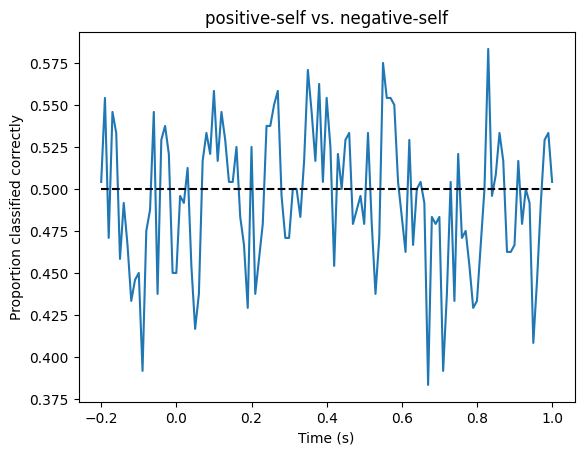

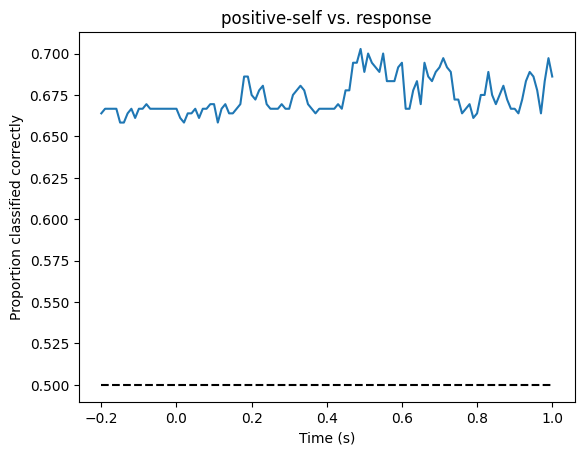

In [10]:
#%% RUN FUNCTION
sensor_pos_neg_self = simple_classication(X_lh_V1,
                                  y, triggers=[11, 12],
                                  penalty='l2', C=1e-3)

sensor_pos_self_response = simple_classication(X_sensor,
                                  y, triggers=[11, 23],
                                  penalty='l2', C=1e-3) # equalize counts?!

#%% PLOT
plot_classfication(times, sensor_pos_neg_self,
                   title='positive-self vs. negative-self')

plot_classfication(times, sensor_pos_self_response,
                   title='positive-self vs. response')